## Chapter 6. Linear Regression and Its Cousins

In [1]:
from rpy2 import robjects
from rpy2.robjects.packages import importr, data
import os
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
base = importr('base')
set_seed = robjects.r("set.seed")
APM = importr('AppliedPredictiveModeling')
APMdatafolder = os.path.expanduser("~/Documents/dataset/AppliedPredictiveModeling/data")
os.path.isdir(APMdatafolder)

True

In [3]:
data_filename='solubility.RData'

In [4]:
#name_ = os.path.splitext(filename)[0]
#name_path = os.path.join(APMdatafolder, name_)
file_path = os.path.join(APMdatafolder, data_filename)

In [5]:
datadict = pyreadr.read_r(file_path)

In [6]:
datadict.keys()

odict_keys(['solTestX', 'solTestXtrans', 'solTestY', 'solTrainX', 'solTrainXtrans', 'solTrainY'])

In [7]:
solTestX, solTestXtrans, solTestY, solTrainX, solTrainXtrans, solTrainY \
= datadict['solTestX'], datadict['solTestXtrans'], datadict['solTestY'], datadict['solTrainX'], datadict['solTrainXtrans'], datadict['solTrainY']

In [21]:
# lowess (local smoother)
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [51]:
def plotContinuousPredictors(X, y, nrows=4, ncols=5):
    '''plot the continous predictors (default 20) versus the outcome'''
    fig, axarr = plt.subplots(nrows, ncols, figsize = (16,9))
    fig.tight_layout()
    
    for r in range(nrows):
        for c in range(ncols):
            plotOnePredictor(axarr[r, c], X.iloc[:,r*ncols+c], y)
            
def plotOnePredictor(ax, X, y):
    '''plot one predictor versus the outcome'''
    z = lowess(np.squeeze(y), np.squeeze(X), 0.88) # return sorted X and y_fit
    ax.scatter(X, y, alpha=0.4)
    ax.plot(z[:, 0], z[:, 1], 'r', linewidth=2)
    ax.set_title(X.name)

In [37]:
contPredictor20List = ['NumRings','NumRotBonds','NumSulfer','SurfaceArea1','SurfaceArea2','NumMultBonds','NumNitrogen','NumNonHAtoms','NumNonHBonds','NumOxygen',\
                      'NumCarbon','NumChlorine','NumDblBonds','NumHalogen','NumHydrogen','HydrophilicFactor','MolWeight','NumAromaticBonds','NumAtoms','NumBonds']

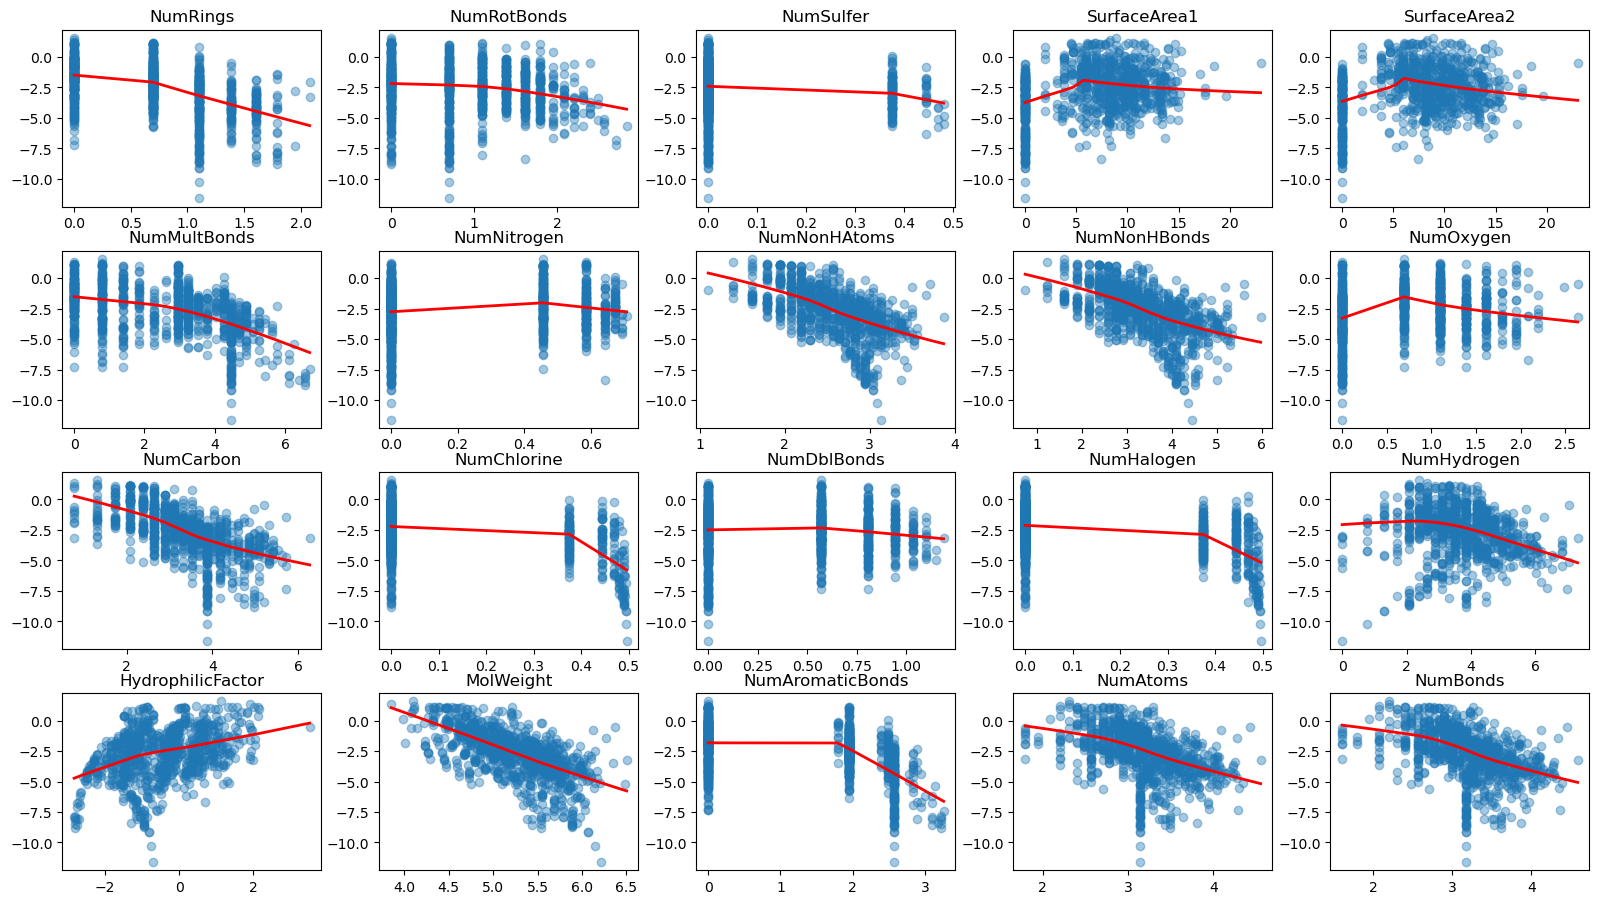

In [52]:
plotContinuousPredictors(solTrainXtrans[contPredictor20List], solTrainY)

<Axes: >

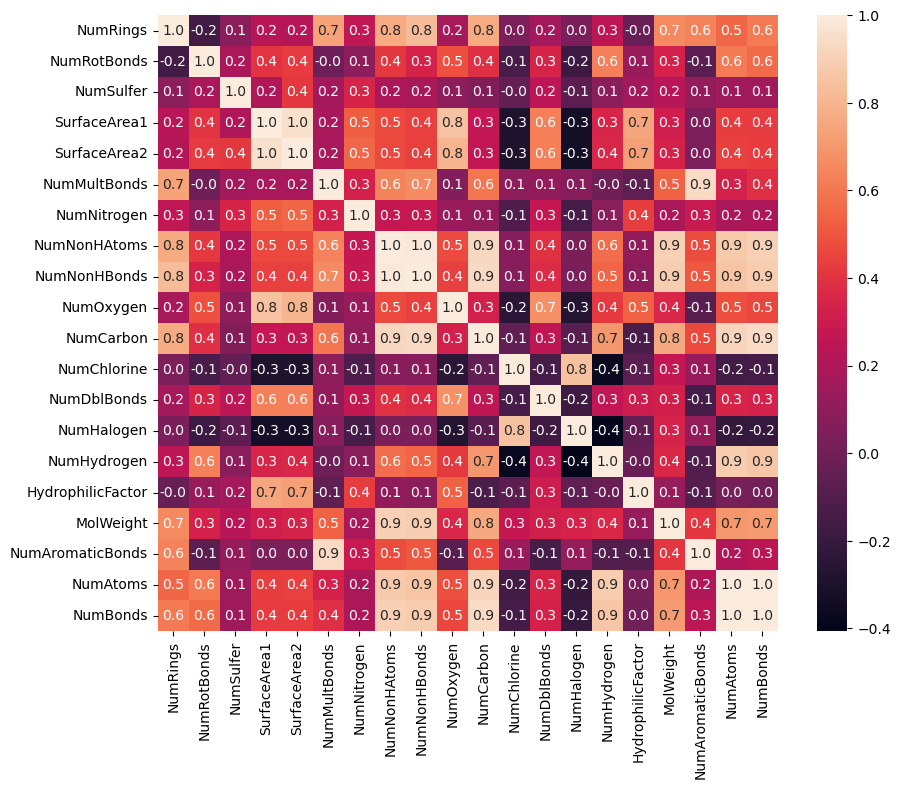

In [67]:
f = plt.figure(figsize=(10,8))
sns.heatmap(solTrainXtrans[contPredictor20List].corr(),annot = True, fmt = ".1f")

In [152]:
corr_df = solTrainXtrans.corr()
for i in range(len(corr_df)):
    corr_df.iloc[i,i] = 0
abs_corr = np.abs(np.array(corr_df))
columnnames = list(corr_df)

while abs_corr.max() > 0.9:
    i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape)
    #print(i,j, abs_corr.max())
    if abs_corr[i,].mean()> abs_corr[j,].mean():
        k = i
    else:
        k = j
    print(k, columnnames.pop(k))
    abs_corr = np.delete(abs_corr, k, axis = 0)
    abs_corr = np.delete(abs_corr, k, axis = 1)

211 NumBonds
133 FP134
57 FP058
209 NumNonHBonds
218 NumChlorine
218 NumHalogen
205 FP208
180 FP183
13 FP014
189 FP194
211 NumNitrogen
208 NumAromaticBonds
31 FP033
161 FP166
0 FP001
173 FP180
211 SurfaceArea2
16 FP019
167 FP175
159 FP167
134 FP141
26 FP030
35 FP041
18 FP022
48 FP056
90 FP100
150 FP163
190 NumNonHAtoms
3 FP005
20 FP026
0 FP002
74 FP087
185 NumAtoms
5 FP009
8 FP013
52 FP067
11 FP018


In [159]:
np.array(np.abs(corr_df.loc[columnnames][columnnames])).max()

0.8969106399505078

### Ordinary Linear Regression

In [8]:
trainingData, Solubility = solTrainXtrans, solTrainY

In [9]:
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Columns: 228 entries, FP001 to SurfaceArea2
dtypes: float64(20), int32(208)
memory usage: 921.4 KB


In [10]:
trainingData.describe()

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,...,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,0.493165,0.539432,0.436383,0.584648,0.579390,0.400631,0.363828,0.325973,0.279706,0.178759,...,3.323978,0.230838,0.747016,0.049753,0.090982,0.120103,0.734091,-0.452796,6.707718,7.081455
std,0.500216,0.498705,0.496197,0.493042,0.493917,0.490284,0.481353,0.468984,0.449091,0.383352,...,0.986043,0.273948,0.627577,0.130874,0.177213,0.194420,0.538622,1.041293,4.508620,4.672059
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.770481,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-2.841320,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.642633,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-1.250963,3.837096,4.159049
50%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.317541,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,-0.363024,7.258130,7.759912
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,3.862179,0.456826,1.098612,-0.000000,-0.000000,0.375000,1.098612,0.279867,9.853650,10.499942
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,6.267798,0.707935,2.639057,0.480000,0.495868,0.495868,2.079442,3.533785,23.020337,23.020337


In [11]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, ShuffleSplit

In [12]:
reg = linear_model.LinearRegression()

In [13]:
reg.fit(trainingData, Solubility)

LinearRegression()

In [14]:
np.sqrt(mean_squared_error(solTestY,reg.predict(solTestXtrans))), r2_score(solTestY,reg.predict(solTestXtrans))

(0.745580189650895, 0.8709146842068274)

In [15]:
cv = ShuffleSplit(n_splits = 10, test_size = 0.1, random_state=0)

lm = linear_model.LinearRegression()
train_scores_mse = cross_val_score(lm, trainingData, Solubility, cv=cv, scoring = 'neg_mean_squared_error')
train_scores_rmse = np.sqrt(-1.0 * train_scores_mse)

train_scores_r2 = cross_val_score(lm, trainingData, Solubility, cv=cv, scoring = 'r2')

In [16]:
train_scores_rmse, train_scores_r2

(array([0.68718958, 0.69942146, 0.71880894, 0.71203498, 0.64933332,
        0.72064067, 0.61727851, 0.73817555, 0.66834284, 0.76232353]),
 array([0.90122112, 0.89944401, 0.86531833, 0.86458914, 0.90364644,
        0.8673618 , 0.88816774, 0.87395627, 0.88157581, 0.83031673]))

In [17]:
np.mean(train_scores_rmse), np.mean(train_scores_r2)

(0.6973549377790128, 0.8775597385382561)

<Axes: xlabel='predicted', ylabel='residual'>

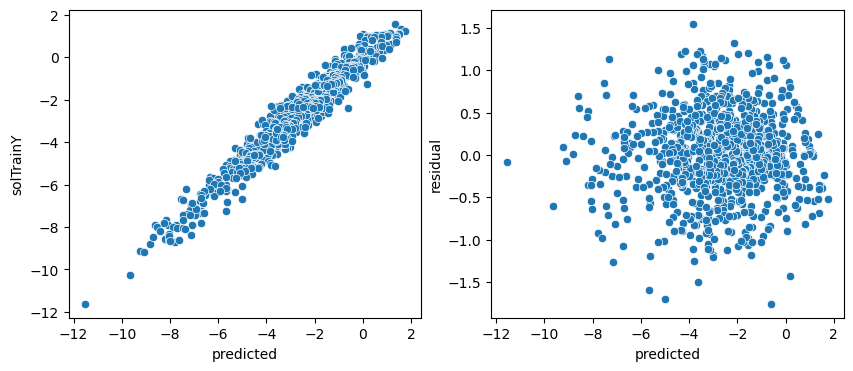

In [18]:
plotdata = solTrainY.copy()
plotdata['predicted'] = reg.predict(solTrainXtrans)
plotdata['residual'] = plotdata['solTrainY']-plotdata['predicted']
f = plt.figure(figsize=(10,4))
ax1 = f.add_subplot(121)
sns.scatterplot(plotdata, x = 'predicted', y='solTrainY',ax = ax1)
ax2 = f.add_subplot(122)
sns.scatterplot(plotdata, x = 'predicted', y='residual',ax = ax2)

### Using Statsmodel package for model summary

In [19]:
import statsmodels.api as sm
X = sm.add_constant(trainingData)
results = sm.OLS(Solubility,X).fit()
summary = results.summary()
r2_score(solTestY,results.predict(sm.add_constant(solTestXtrans)))

0.8709146842068282

In [20]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              solTrainY   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     54.03
Date:                Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                        10:25:01   Log-Likelihood:                -654.04
No. Observations:                 951   AIC:                             1766.
Df Residuals:                     722   BIC:                             2878.
Df Model:                         228                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4307      2.162      1.124      0.261      -1.814       6.676
FP001                 0.3594      0.319      1.128      0.260      -0.266       0.985
FP002                 0.1456      0.264      0.552      0.581      -0.372       0.663
FP003                -0.0397      0.131     -0.302      0.763      -0.298       0.218
FP004                -0.3049      0.137     -2.223      0.027      -0.574      -0.036
FP005                 2.8367      0.960      2.956      0.003       0.952       4.721
FP006                -0.0689      0.204     -0.337      0.736      -0.470       0.332
FP007                 0.0404      0.115      0.351      0.726      -0.186       0.267
FP008                 0.1121      0.164      0.685      0.493      -0.209       0.433
FP009                -0.8242      0.840     -0.982      0.327      -2.472       0.824
FP010                 0.4193      0.314      1.337      0.182      -0.196       1.035
FP011                 0.0516      0.220      0.235      0.815      -0.380       0.483
FP012                -0.0135      0.161     -0.084      0.933      -0.330       0.303
FP013                -0.4519      0.547     -0.826      0.409      -1.526       0.623
FP014                 0.3281      0.455      0.721      0.471      -0.565       1.221
FP015                -0.1839      0.152     -1.209      0.227      -0.483       0.115
FP016                -0.1367      0.155     -0.883      0.377      -0.441       0.167
FP017                -0.1704      0.139     -1.230      0.219      -0.443       0.102
FP018                -0.3824      0.239     -1.602      0.110      -0.851       0.086
FP019                -0.3131      0.386     -0.811      0.418      -1.071       0.445
FP020                 0.2072      0.213      0.971      0.332      -0.212       0.626
FP021                -0.0596      0.263     -0.226      0.821      -0.576       0.457
FP022                 0.2336      0.346      0.676      0.499      -0.445       0.912
FP023                -0.3193      0.191     -1.672      0.095      -0.694       0.056
FP024                -0.4272      0.283     -1.511      0.131      -0.982       0.128
FP025                 0.4376      0.454      0.964      0.335      -0.453       1.329
FP026                 0.2068      0.256      0.806      0.420      -0.297       0.710
FP027                 0.2424      0.243      0.998      0.319      -0.234       0.719
FP028                 0.1070      0.120      0.892      0.373      -0.128       0.343
FP029                -0.0986      0.220     -0.448      0.654      -0.530       0.333
FP030                -0.2361      0.247     -0.957      0.339      -0.721       0.248
FP031                 0.0869      0.135      0.646      0.519      -0.177       0.351
FP032                -1.2045      0.777     -1.550      0.122      -2.730